# Pro Tennis Predictions
Tom Smith and Eli Ingleson

## Business Problem

Our business problem was to identify aspects of a tennis match that lead to success and use these features to predict the winner of a professional match. This could be useful for gamblers as well as curious tennis fanatics.

## Initial Imports

In [414]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_auc_score, plot_roc_curve
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import ComplementNB, GaussianNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.datasets import make_friedman1
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score, cross_validate
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.impute import SimpleImputer
import numpy as np
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore')

## Data Imports

We are getting all our data from Jeff Sachman's github page "tennis-atp", which is linked here: https://github.com/JeffSackmann/tennis_atp. He has CSV's going all the way back to 1968 with recorded atp matches and their stats. However, we are only going to use data going back to 1991. This is because Jeff mentioned that some of the data was incomplete once you go past that threshold. This data is updated on a weekly basis.

In [415]:
# Reading in data
years = [1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001,
         2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 
         2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
dfs = []
for year in years:
    df = pd.read_csv(f'https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_matches_{year}.csv')
    df['year'] = year
    dfs.append(df)
match_df = pd.concat(dfs)

##  Initial Data Exploration

Here, we are going to just look over the data and draw some initial thoughts about how to proceed.

In [416]:
match_df.head()

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,...,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,year
0,1991-339,Adelaide,Hard,32,A,19901231,1,101723,NaN,NaN,...,44.0,23.0,16.0,6.0,8.0,56.0,NaN,2.0,NaN,1991
1,1991-339,Adelaide,Hard,32,A,19901231,2,100946,NaN,Q,...,35.0,27.0,15.0,1.0,2.0,304.0,NaN,75.0,NaN,1991
2,1991-339,Adelaide,Hard,32,A,19901231,3,101234,NaN,NaN,...,22.0,6.0,8.0,4.0,8.0,82.0,NaN,69.0,NaN,1991
3,1991-339,Adelaide,Hard,32,A,19901231,4,101889,8,NaN,...,30.0,11.0,10.0,5.0,8.0,50.0,NaN,84.0,NaN,1991
4,1991-339,Adelaide,Hard,32,A,19901231,5,101274,NaN,NaN,...,28.0,15.0,11.0,4.0,8.0,88.0,NaN,28.0,NaN,1991


In [417]:
match_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101396 entries, 0 to 1999
Data columns (total 50 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   tourney_id          101396 non-null  object 
 1   tourney_name        101396 non-null  object 
 2   surface             101396 non-null  object 
 3   draw_size           101396 non-null  int64  
 4   tourney_level       101396 non-null  object 
 5   tourney_date        101396 non-null  int64  
 6   match_num           101396 non-null  int64  
 7   winner_id           101396 non-null  int64  
 8   winner_seed         41057 non-null   object 
 9   winner_entry        12307 non-null   object 
 10  winner_name         101396 non-null  object 
 11  winner_hand         101387 non-null  object 
 12  winner_ht           99101 non-null   float64
 13  winner_ioc          101396 non-null  object 
 14  winner_age          101393 non-null  float64
 15  loser_id            101396 non-null 

It appears that we have a lot of nulls in winner/loser seed and entry. We also have several columns that are objects and not floats. In order for us to run any models, we are going to have to change these types to either be numeric or have boolean values. However, many of these columns we do not believe are necessary for our models, and we can drop them.

## Data Cleaning

### Dropping Unneeded Columns

To start our data cleaning off, we are going to drop unnecessary columns. We are going to drop winner/loser ioc. This is the player's country of origin, and we believe that it will not have an effect on whether they will win or lose. We are also going to drop tourney_name, tourney_id, round, and tourney_level as we are trying to predict matches on an individual basis, rather than that in a specific tournament setting. We are going to drop score and minutes, since we do not care about them. We just care who won, not how close or long the match was. Winner seed and Winner entry are not needed for individual match predictions. Furthermore, we only need rank and not ranking points, so we will drop that as well. The last things we are going to drop is winner/loser hand, ht, and age. The remaining information will help us provide answers to the business problem stated above.

In [418]:
match_df = match_df.drop(columns = ['tourney_id', 'tourney_name', 'tourney_level', 'winner_ioc', 'loser_ioc',
                                   'match_num', 'winner_entry', 'loser_entry', 'score', 'winner_hand', 'loser_hand', 
                                   'winner_rank_points', 'loser_rank_points', 'minutes', 'loser_ht', 'winner_ht', 
                                   'winner_seed', 'loser_seed', 'round', 'winner_age', 'loser_age', 
                                   'draw_size', 'best_of'])

### Dealing with NaN's

In [419]:
match_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101396 entries, 0 to 1999
Data columns (total 27 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   surface       101396 non-null  object 
 1   tourney_date  101396 non-null  int64  
 2   winner_id     101396 non-null  int64  
 3   winner_name   101396 non-null  object 
 4   loser_id      101396 non-null  int64  
 5   loser_name    101396 non-null  object 
 6   w_ace         91330 non-null   float64
 7   w_df          91330 non-null   float64
 8   w_svpt        91330 non-null   float64
 9   w_1stIn       91330 non-null   float64
 10  w_1stWon      91330 non-null   float64
 11  w_2ndWon      91330 non-null   float64
 12  w_SvGms       91331 non-null   float64
 13  w_bpSaved     91330 non-null   float64
 14  w_bpFaced     91330 non-null   float64
 15  l_ace         91330 non-null   float64
 16  l_df          91330 non-null   float64
 17  l_svpt        91330 non-null   float64
 18  l_1stI

Most of our nulls are in columns dealing with game statistics. We are going to drop these rows, as we do not believe that we could fill them with anything accurately.

In [420]:
match_df = match_df.dropna()

### Converting Datatypes to Numeric

We do not have any nulls now. To compare our columns and make models in the future, we need to get our categorical columns to become numeric. Therefore, we are going to encode surface.

In [421]:
match_df["surface"] = match_df["surface"].astype('category')
match_df.dtypes
match_df["surface_cat"] = match_df["surface"].cat.codes

Now, since we have surface_cats as an int, we no longer need 'surface.' Our new surface_cats columns has 1 as clay, 2 as grass, 3 as hard. It also has 0 as carpet.

In [422]:
match_df = match_df.drop(columns = 'surface')

In [423]:
match_df = match_df.reset_index(drop=True)

## Creating our Target Column: fav_win

This column will allow us to see if the favorite won the match or not. This will be our target column for when we begin modelling, and we will put the rest of the data in terms of who is the favorite.

In [424]:
# Creating variables for a loop to iterate through
winners_r = match_df['winner_rank']
losers_r = match_df['loser_rank']

In [425]:
# This for loop finds whether or not the highest ranked player won or not for each match and adds it to a new list.
favorites = []
for i in list(range(0, len(match_df))):
    if winners_r[i] > losers_r[i]:             
        favorites.append(False)
    elif winners_r[i] < losers_r[i]:
        favorites.append(True)
favorites

[False,
 False,
 False,
 True,
 False,
 False,
 True,
 True,
 True,
 True,
 False,
 False,
 False,
 True,
 True,
 True,
 False,
 True,
 False,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 True,
 True,
 False,
 False,
 True,
 False,
 True,
 False,
 True,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 False,
 False,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 False,
 True,
 True,
 True,
 False,
 True,
 True,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 False,
 False,
 True,
 True,
 True,
 False,
 False,
 True,
 False,
 False,
 False,
 True,
 False,
 False,
 True,
 False,
 True,
 False,
 True,
 False,
 False,
 False,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 True,
 False,
 False,
 True,
 True,

In [426]:
# Creating our fav_win column using the favorites list
match_df['fav_win'] = favorites

In [427]:
match_df.columns

Index(['tourney_date', 'winner_id', 'winner_name', 'loser_id', 'loser_name',
       'w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon', 'w_SvGms',
       'w_bpSaved', 'w_bpFaced', 'l_ace', 'l_df', 'l_svpt', 'l_1stIn',
       'l_1stWon', 'l_2ndWon', 'l_SvGms', 'l_bpSaved', 'l_bpFaced',
       'winner_rank', 'loser_rank', 'year', 'surface_cat', 'fav_win'],
      dtype='object')

### Aggregate player stats
In order for our model to not have target/data leakage, we are changing the columns to describe their career averages (career stats limited to results within this data's timeframe). Each row will still represent a match with two competitors, but the other columns describing matchplay will not be specific to that individual match, therefore the model should not be using future data to predict future results. Players perform differently according to surface and year of play, so we grouped our data so that averages would be calculated per surface per year. This way our model can have context on environment and momentum of any given player.

In [428]:
# Changing tourney_date from an object to a datetime
match_df['tourney_date'] = pd.to_datetime(match_df['tourney_date'], format='%Y%m%d')

In [429]:
match_df['prev_year'] = match_df['tourney_date'].dt.year - 1

In [430]:
# Grouping where the favorite wins and averaging each player's stats
match_dfW = match_df.groupby(['winner_id', 'year', 'surface_cat']).mean()[['w_df',             
'w_svpt',             
   'w_1stIn',            
   'w_1stWon',           
   'w_2ndWon',           
'w_SvGms',            
  'w_bpSaved',          
  'w_bpFaced',
                                                'w_ace'
    ]]

In [431]:
# Grouping where favorite losees and averaging each player's stats
match_dfL = match_df.groupby(['loser_id', 'year', 'surface_cat']).mean()[['l_ace',              
  'l_df',               
  'l_svpt',             
  'l_1stIn',            
 'l_1stWon',           
  'l_2ndWon',           
  'l_SvGms',            
 'l_bpSaved',          
  'l_bpFaced',
    ]]

In [432]:
match_df = match_df.merge(match_dfW, 
              left_on = ['winner_id', 'prev_year', 'surface_cat'], 
              right_on = ['winner_id', 'year', 'surface_cat'],
              suffixes = ('_match', '_winner'),
              how = 'left')

In [433]:
match_df = match_df.merge(match_dfL, 
              left_on = ['loser_id', 'prev_year', 'surface_cat'], 
              right_on = ['loser_id', 'year', 'surface_cat'],
              suffixes = ('_match', '_loser'),
              how = 'left')

In [434]:
match_df = match_df.drop(columns = ['w_ace_match',
       'w_df_match', 'w_svpt_match', 'w_1stIn_match', 'w_1stWon_match',
       'w_2ndWon_match', 'w_SvGms_match', 'w_bpSaved_match', 'w_bpFaced_match',
       'l_ace_match', 'l_df_match', 'l_svpt_match', 'l_1stIn_match',
       'l_1stWon_match', 'l_2ndWon_match', 'l_SvGms_match', 'l_bpSaved_match',
       'l_bpFaced_match', ])

In [435]:
match_df['year'].unique()

array([1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001,
       2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012,
       2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022],
      dtype=int64)

## Differences
In order for us to engineer the data in terms of favorite, which will allow our model to have an easily identifiable target, we have to include a column that outputs boolean True or False to whether or not the favorite won. This is calculated by looking at player rankings going into any individual match, which was provided in the original dataset.

In [436]:
favorites = []
for i in list(range(0, len(match_df))):
    if winners_r[i] > losers_r[i]:             
        favorites.append(False)
    elif winners_r[i] < losers_r[i]:
        favorites.append(True)
favorites

[False,
 False,
 False,
 True,
 False,
 False,
 True,
 True,
 True,
 True,
 False,
 False,
 False,
 True,
 True,
 True,
 False,
 True,
 False,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 True,
 True,
 False,
 False,
 True,
 False,
 True,
 False,
 True,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 False,
 False,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 False,
 True,
 True,
 True,
 False,
 True,
 True,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 False,
 False,
 True,
 True,
 True,
 False,
 False,
 True,
 False,
 False,
 False,
 True,
 False,
 False,
 True,
 False,
 True,
 False,
 True,
 False,
 False,
 False,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 True,
 False,
 False,
 True,
 True,

In [437]:
match_df['fav_win'] = favorites

In [438]:
match_df.columns

Index(['tourney_date', 'winner_id', 'winner_name', 'loser_id', 'loser_name',
       'winner_rank', 'loser_rank', 'year', 'surface_cat', 'fav_win',
       'prev_year', 'w_df_winner', 'w_svpt_winner', 'w_1stIn_winner',
       'w_1stWon_winner', 'w_2ndWon_winner', 'w_SvGms_winner',
       'w_bpSaved_winner', 'w_bpFaced_winner', 'w_ace_winner', 'l_ace_loser',
       'l_df_loser', 'l_svpt_loser', 'l_1stIn_loser', 'l_1stWon_loser',
       'l_2ndWon_loser', 'l_SvGms_loser', 'l_bpSaved_loser',
       'l_bpFaced_loser'],
      dtype='object')

In [439]:
fav_win_T = match_df.loc[match_df['fav_win'] == True]

In [440]:
fav_win_T['fav_rank_diff'] = fav_win_T['winner_rank'] - fav_win_T['loser_rank']
fav_win_T['fav_bpFaced_diff'] = fav_win_T['w_bpFaced_winner'] - fav_win_T['l_bpFaced_loser']
fav_win_T['fav_bpSaved_diff'] = fav_win_T['w_bpSaved_winner'] - fav_win_T['l_bpSaved_loser']
fav_win_T['fav_SvGms_diff'] = fav_win_T['w_SvGms_winner'] - fav_win_T['l_SvGms_loser']
fav_win_T['fav_2ndWon_diff'] = fav_win_T['w_2ndWon_winner'] - fav_win_T['l_2ndWon_loser']
fav_win_T['fav_1stWon_diff'] = fav_win_T['w_1stWon_winner'] - fav_win_T['l_1stWon_loser']
fav_win_T['fav_1stIn_diff'] = fav_win_T['w_1stIn_winner'] - fav_win_T['l_1stIn_loser']
fav_win_T['fav_svpt_diff'] = fav_win_T['w_svpt_winner'] - fav_win_T['l_svpt_loser']
fav_win_T['fav_df_diff'] = fav_win_T['w_df_winner'] - fav_win_T['l_df_loser']
fav_win_T['fav_ace_diff'] = fav_win_T['w_ace_winner'] - fav_win_T['l_ace_loser']

In [441]:
# dropping not diff columns
fav_win_T = fav_win_T.drop(columns = ['w_df_winner',
       'w_svpt_winner', 'w_1stIn_winner', 'w_1stWon_winner', 'w_2ndWon_winner',
       'w_SvGms_winner', 'w_bpSaved_winner', 'w_bpFaced_winner',
       'w_ace_winner', 'l_ace_loser', 'l_df_loser', 'l_svpt_loser',
       'l_1stIn_loser', 'l_1stWon_loser', 'l_2ndWon_loser', 'l_SvGms_loser',
       'l_bpSaved_loser', 'l_bpFaced_loser'])

In [442]:
fav_win_F = match_df.loc[match_df['fav_win'] == False]

In [443]:
fav_win_F['fav_rank_diff'] =fav_win_F['loser_rank'] - fav_win_F['winner_rank'] 
fav_win_F['fav_bpFaced_diff'] =fav_win_F['l_bpFaced_loser'] - fav_win_F['w_bpFaced_winner']  
fav_win_F['fav_bpSaved_diff'] =fav_win_F['l_bpSaved_loser'] - fav_win_F['w_bpSaved_winner']  
fav_win_F['fav_SvGms_diff'] =fav_win_F['l_SvGms_loser'] - fav_win_F['w_SvGms_winner'] 
fav_win_F['fav_2ndWon_diff'] =fav_win_F['l_2ndWon_loser'] - fav_win_F['w_2ndWon_winner']  
fav_win_F['fav_1stWon_diff'] =fav_win_F['l_1stWon_loser'] - fav_win_F['w_1stWon_winner']  
fav_win_F['fav_1stIn_diff'] =fav_win_F['l_1stIn_loser'] - fav_win_F['w_1stIn_winner'] 
fav_win_F['fav_svpt_diff'] =fav_win_F['l_svpt_loser'] - fav_win_F['w_svpt_winner'] 
fav_win_F['fav_df_diff'] =fav_win_F['l_df_loser'] - fav_win_F['w_df_winner']  
fav_win_F['fav_ace_diff'] =fav_win_F['l_ace_loser'] - fav_win_F['w_ace_winner']  

In [444]:
fav_win_F = fav_win_F.drop(columns = ['w_df_winner',
       'w_svpt_winner', 'w_1stIn_winner', 'w_1stWon_winner', 'w_2ndWon_winner',
       'w_SvGms_winner', 'w_bpSaved_winner', 'w_bpFaced_winner',
       'w_ace_winner', 'l_ace_loser', 'l_df_loser', 'l_svpt_loser',
       'l_1stIn_loser', 'l_1stWon_loser', 'l_2ndWon_loser', 'l_SvGms_loser',
       'l_bpSaved_loser', 'l_bpFaced_loser'])

In [445]:
agg_df = pd.concat([fav_win_T, fav_win_F]).sort_values(by = 'tourney_date')

In [446]:
agg_df.head()

,tourney_date,winner_id,winner_name,loser_id,loser_name,winner_rank,loser_rank,year,surface_cat,fav_win,...,fav_rank_diff,fav_bpFaced_diff,fav_bpSaved_diff,fav_SvGms_diff,fav_2ndWon_diff,fav_1stWon_diff,fav_1stIn_diff,fav_svpt_diff,fav_df_diff,fav_ace_diff
3,1990-12-31,101889,Todd Woodbridge,101703,Guillaume Raoux,50.0,84.0,1991,3,True,...,-34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
54,1990-12-31,101377,Christian Bergstrom,101432,Dimitri Poliakov,80.0,172.0,1991,3,True,...,-92.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55,1990-12-31,101735,Richard Fromberg,100752,Ramesh Krishnan,32.0,79.0,1991,3,True,...,-47.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
56,1990-12-31,101481,Omar Camporese,100962,Thomas Hogstedt,45.0,91.0,1991,3,True,...,-46.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
57,1990-12-31,101767,Lars Jonsson,101354,Andrew Sznajder,100.0,104.0,1991,3,True,...,-4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Model-less Baseline

Let's see how we can predict future matches prior to making any models

In [447]:
agg_df['fav_win'].value_counts()

True     58820
False    31874
Name: fav_win, dtype: int64

In [448]:
58820 / len(agg_df['fav_win'])

0.648554479899442

Our model-less baseline is about 65% accurate if you were to predict that the favorite won every time.

## Train-Test Split
Our next step is to conduct a Train-Test split and create a holdout set. We dropped columns that would not help our model make predictions. 

In [449]:
# Our holdout set will be on data from 2021 on
test_df = agg_df.loc[agg_df['year'] >= 2021]

In [500]:
X = agg_df.drop(columns='fav_win')
y = agg_df['fav_win']
# Preparing our hold out data for train test split
X_cols = X.columns
X_train, X_test, y_train, y_test= train_test_split(X, y, random_state=2022, test_size=len(test_df), shuffle = False)
X_test, X_hold, y_test, y_hold = train_test_split(X_test, y_test, test_size=500, shuffle=False)

In [501]:
X_train = X_train.drop(columns = ['tourney_date', 'winner_name', 'loser_name', 'winner_id', 'loser_id', 'prev_year',
                                 'winner_rank', 'loser_rank', 'year'])
X_test = X_test.drop(columns = ['tourney_date', 'winner_name', 'loser_name', 'winner_id', 'loser_id', 'prev_year',
                               'winner_rank', 'loser_rank', 'year'])
X_hold = X_hold.drop(columns = ['tourney_date', 'winner_name', 'loser_name', 'winner_id', 'loser_id', 'prev_year', 
                                'winner_rank', 'loser_rank', 'year'])

## Function

In [502]:
X_train = X_train.drop(columns='fav_rank_diff')
X_test = X_test.drop(columns='fav_rank_diff')
X_hold = X_hold.drop(columns='fav_rank_diff')

In [504]:
X_train = X_train.drop(columns = 'surface_cat')
X_test = X_test.drop(columns = 'surface_cat')
X_hold = X_hold.drop(columns = 'surface_cat')

The function below will allow our notebook to be more readable and concise. By plugging in X_train, X_test, y_train, and y_test, this function will return a confusion matrix, a roc-auc graph, and the scores for each model.

In [505]:
def evaluate(model,Xtr,Xte,ytr,yte):
    train_preds = model.predict(Xtr)
    test_preds = model.predict(Xte)

    train_probas = model.predict_proba(Xtr)[:,1]
    test_probas = model.predict_proba(Xte)[:,1]
    
    plot_confusion_matrix(model,Xte,yte)
    
    plot_roc_curve(model,Xte,yte)
    
    print(f"Train Accuracy: {accuracy_score(ytr,train_preds):.4f}")
    print(f"Train F1: {f1_score(ytr,train_preds):.4f}")
    print(f"Train Precision: {precision_score(ytr,train_preds):.4f}")
    print(f"Train Recall: {recall_score(ytr,train_preds):.4f}")
    print(f"Train ROC-AUC: {roc_auc_score(ytr,train_probas):.4f}")
    print('*'*20)
    print(f"Test Accuracy: {accuracy_score(yte,test_preds):.4f}")
    print(f"Test F1: {f1_score(yte,test_preds):.4f}")
    print(f"Test Precision: {precision_score(yte,test_preds):.4f}")
    print(f"Test Recall: {recall_score(yte,test_preds):.4f}")
    print(f"Test ROC-AUC: {roc_auc_score(yte,test_probas):.4f}")

## LOGREG MODEL 

The first model we are going to run is a Logisitic Regression. This will be the simplest model we chose to run.

In [506]:
si = SimpleImputer()

si.fit(X_train)

X_train_im = si.transform(X_train)
X_test_im = si.transform(X_test)
X_hold_im = si.transform(X_hold)

In [507]:
scaler = StandardScaler()

scaler.fit(X_train_im)

X_train_sc = scaler.transform(X_train_im)
X_test_sc = scaler.transform(X_test_im)
X_hold_sc = scaler.transform(X_hold_im)

In [508]:
logreg = LogisticRegression(penalty = 'l2', random_state = 42, C = .5)

logreg.fit(X_train_sc,y_train)

LogisticRegression(C=0.5, random_state=42)

Train Accuracy: 0.8784
Train F1: 0.9123
Train Precision: 0.8577
Train Recall: 0.9743
Train ROC-AUC: 0.9482
********************
Test Accuracy: 0.8722
Test F1: 0.9068
Test Precision: 0.8446
Test Recall: 0.9789
Test ROC-AUC: 0.9441


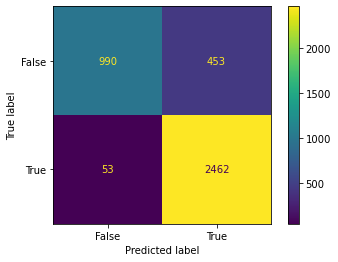

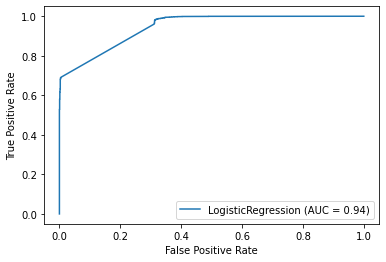

In [509]:
evaluate(logreg,X_train_sc,X_test_sc,y_train,y_test)

## Model 2: Decision Tree

Our second model is going to be a decision tree. This could possibly help with class imbalance as shown in model-less baseline. The favorite wins more often than not, so a DT might force the model to predict the minority more often.

In [510]:
tree = DecisionTreeClassifier(random_state = 42,max_depth = 5)

tree.fit(X_train_im, y_train)

DecisionTreeClassifier(max_depth=5, random_state=42)

Train Accuracy: 0.8687
Train F1: 0.9064
Train Precision: 0.8437
Train Recall: 0.9790
Train ROC-AUC: 0.9377
********************
Test Accuracy: 0.8535
Test F1: 0.8942
Test Precision: 0.8261
Test Recall: 0.9746
Test ROC-AUC: 0.9270


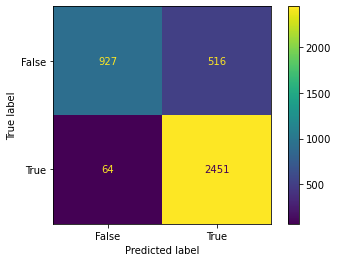

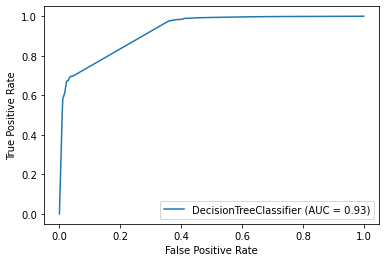

In [511]:
evaluate(tree,X_train_im,X_test_im,y_train,y_test)

## Model 3: Naive Bayes

In [512]:
clf_nb = Pipeline(steps = [
    ('scaler', StandardScaler()),
    ('naive_bayes', GaussianNB()),
])

clf_nb.fit(X_train_im,y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('naive_bayes', GaussianNB())])

Train Accuracy: 0.8302
Train F1: 0.8775
Train Precision: 0.8250
Train Recall: 0.9373
Train ROC-AUC: 0.8897
********************
Test Accuracy: 0.8108
Test F1: 0.8614
Test Precision: 0.8055
Test Recall: 0.9256
Test ROC-AUC: 0.8794


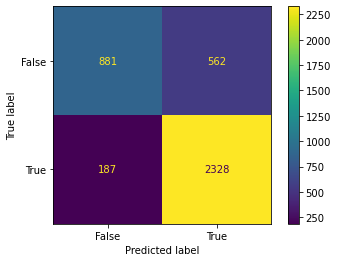

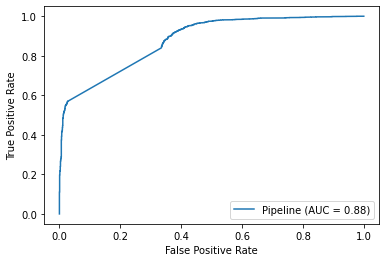

In [513]:
evaluate(clf_nb,X_train_im,X_test_im,y_train,y_test)

## Model 4: Random Forest

In [514]:
smote = SMOTE(random_state=42)
X_train_im, y_train2 = smote.fit_resample(X_train_im,y_train)

In [515]:
clf_rf = Pipeline(steps = [
    ('scaler', StandardScaler()),
    ('random forest', RandomForestClassifier(random_state=42,max_depth = 10)),
])

clf_rf.fit(X_train_im,y_train2)

Pipeline(steps=[('scaler', StandardScaler()),
                ('random forest',
                 RandomForestClassifier(max_depth=10, random_state=42))])

In [516]:
cross_validate(clf_rf,X_train_im,y_train2,scoring='accuracy',return_train_score = True)

{'fit_time': array([25.61123896, 24.64875364, 24.64553666, 23.81064224, 23.93048573]),
 'score_time': array([0.29687929, 0.31249857, 0.29686475, 0.31252623, 0.3125    ]),
 'test_score': array([0.79902661, 0.86809556, 0.86028131, 0.89113641, 0.87966064]),
 'train_score': array([0.88315472, 0.86609884, 0.86771748, 0.86084103, 0.86336388])}

Train Accuracy: 0.8676
Train F1: 0.8493
Train Precision: 0.9854
Train Recall: 0.7462
Train ROC-AUC: 0.9583
********************
Test Accuracy: 0.8072
Test F1: 0.8240
Test Precision: 0.9813
Test Recall: 0.7101
Test ROC-AUC: 0.9450


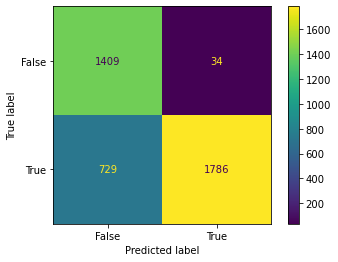

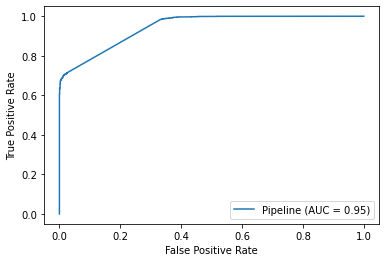

In [517]:
evaluate(clf_rf,X_train_im,X_test_im,y_train2,y_test)

## Final Model

For our models, we found our logreg model to have the best score and the smallest difference between its test and train scores. We are going to test this model on our holdout set next.

## Holdout Set

Train Accuracy: 0.8784
Train F1: 0.9123
Train Precision: 0.8577
Train Recall: 0.9743
Train ROC-AUC: 0.9482
********************
Test Accuracy: 0.8460
Test F1: 0.8892
Test Precision: 0.8175
Test Recall: 0.9748
Test ROC-AUC: 0.9041


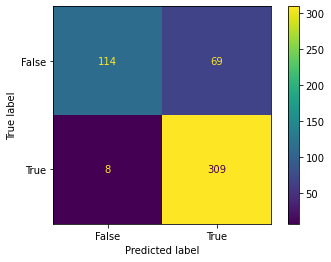

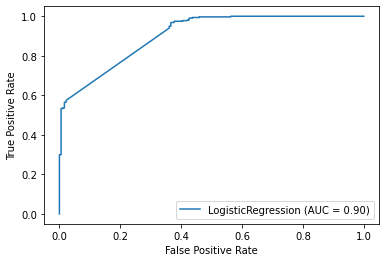

In [518]:
evaluate(logreg,X_train_sc,X_hold_sc,y_train,y_hold)

Conclusion: With 9 columns, we can predict the winner of a match with roughly 85% accuracy. 

# Feature Importance

## Building a Match Predictor

The next thing we would like to do is to build a function where we can input two players and a surface, and our function will then spit out who it believes will win using the logreg model above. The function below will allow us to do just that. In the dataframe used above, rows represent a match between two players, and the columns describe the statistics of that individual match. For us to be able to call on any two given players, the data must be restructured so that each row represents a player and the columns describe their averages in a chosen timeframe (we used recent data, 2018-present). The model is then able to compare the two player's aggregate performances and use that information to predict a winner.

In [519]:
match_df

,tourney_date,winner_id,winner_name,loser_id,loser_name,winner_rank,loser_rank,year,surface_cat,fav_win,...,w_ace_winner,l_ace_loser,l_df_loser,l_svpt_loser,l_1stIn_loser,l_1stWon_loser,l_2ndWon_loser,l_SvGms_loser,l_bpSaved_loser,l_bpFaced_loser
0,1990-12-31,101723,Magnus Larsson,101414,Boris Becker,56.0,2.0,1991,3,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1990-12-31,100946,Slobodan Zivojinovic,101256,Mark Kratzmann,304.0,75.0,1991,3,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1990-12-31,101234,Patrik Kuhnen,101421,Veli Paloheimo,82.0,69.0,1991,3,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1990-12-31,101889,Todd Woodbridge,101703,Guillaume Raoux,50.0,84.0,1991,3,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1990-12-31,101274,Udo Riglewski,101843,Sergi Bruguera,88.0,28.0,1991,3,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90689,2022-03-04,202120,Rowland Phillips,133018,Michail Pervolarakis,1390.0,402.0,2022,1,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
90690,2022-03-04,209080,Blaise Bicknell,202065,Petros Tsitsipas,1130.0,808.0,2022,1,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
90691,2022-03-04,209362,Aristotelis Thanos,209080,Blaise Bicknell,1103.0,1130.0,2022,1,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
90692,2022-03-04,202065,Petros Tsitsipas,202120,Rowland Phillips,808.0,1390.0,2022,1,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The columns must match in length and order for us to be able to merge player's losing statistics with their winning stats.

In [520]:
loser_cols = [c for c in match_df.columns if 'loser' in c]
loser_cols.append('surface_cat')
loser_cols

['loser_id',
 'loser_name',
 'loser_rank',
 'l_ace_loser',
 'l_df_loser',
 'l_svpt_loser',
 'l_1stIn_loser',
 'l_1stWon_loser',
 'l_2ndWon_loser',
 'l_SvGms_loser',
 'l_bpSaved_loser',
 'l_bpFaced_loser',
 'surface_cat']

In [521]:
loser_cols.remove('loser_id')
loser_cols.remove('loser_rank')

In [522]:
match_loser = match_df[loser_cols]

In [523]:
winner_cols = [c for c in match_df.columns if 'winner' in c]
winner_cols.append('surface_cat')
winner_cols

['winner_id',
 'winner_name',
 'winner_rank',
 'w_df_winner',
 'w_svpt_winner',
 'w_1stIn_winner',
 'w_1stWon_winner',
 'w_2ndWon_winner',
 'w_SvGms_winner',
 'w_bpSaved_winner',
 'w_bpFaced_winner',
 'w_ace_winner',
 'surface_cat']

In [524]:
len(winner_cols)

13

In [525]:
winner_cols.remove('winner_id')
winner_cols.remove('winner_rank')

In [526]:
winner_cols = ['winner_name',
'w_ace_winner',
 'w_df_winner',
 'w_svpt_winner',
 'w_1stIn_winner',
 'w_1stWon_winner',
 'w_2ndWon_winner',
 'w_SvGms_winner',
 'w_bpSaved_winner',
 'w_bpFaced_winner',
 'surface_cat']

In [527]:
loser_cols

['loser_name',
 'l_ace_loser',
 'l_df_loser',
 'l_svpt_loser',
 'l_1stIn_loser',
 'l_1stWon_loser',
 'l_2ndWon_loser',
 'l_SvGms_loser',
 'l_bpSaved_loser',
 'l_bpFaced_loser',
 'surface_cat']

In [528]:
clean_cols = ['name', 'ace', 'df', 'svpt', '1stIn', '1stWon',
              '2ndWon', 'SvGms', 'bpSaved', 'bpFaced', 'surface_cat']

Dataframe of each player's statistics when winning

In [529]:
match_winner = match_df[winner_cols]
match_winner.head()

,winner_name,w_ace_winner,w_df_winner,w_svpt_winner,w_1stIn_winner,w_1stWon_winner,w_2ndWon_winner,w_SvGms_winner,w_bpSaved_winner,w_bpFaced_winner,surface_cat
0,Magnus Larsson,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
1,Slobodan Zivojinovic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
2,Patrik Kuhnen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
3,Todd Woodbridge,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
4,Udo Riglewski,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3


Replacing column's names (which gave context of win/loss) with a neutral name we can merge both groups of stats on.

In [530]:
match_winner = match_winner.rename(columns=dict(zip(winner_cols, clean_cols)))
match_loser = match_loser.rename(columns=dict(zip(loser_cols, clean_cols)))

In [531]:
match_winner.columns == match_loser.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

Dataframe of combined statistics

In [532]:
match_exp = pd.concat([match_winner, match_loser])

In [533]:
match_exp.columns

Index(['name', 'ace', 'df', 'svpt', '1stIn', '1stWon', '2ndWon', 'SvGms',
       'bpSaved', 'bpFaced', 'surface_cat'],
      dtype='object')

In [534]:
len(match_exp)

181388

In [535]:
match_exp.isna().sum()

name               0
ace            29395
df             29395
svpt           29395
1stIn          29395
1stWon         29395
2ndWon         29395
SvGms          29395
bpSaved        29395
bpFaced        29395
surface_cat        0
dtype: int64

In [536]:
match_exp1 = match_exp.groupby(by = ['name', 'surface_cat'])[['ace', 'df', 'svpt', '1stIn',
       '1stWon', '2ndWon', 'SvGms', 'bpSaved', 'bpFaced']].mean()

In [537]:
match_exp1

ace        df        svpt      1stIn  \
name             surface_cat                                              
Aaron Krickstein 0            4.215079  2.253175   84.698413  48.684921   
                 1            3.080417  2.718333   83.387083  47.712083   
                 2            7.187500  3.104167  113.916667  68.708333   
                 3            4.293890  2.292266   81.666477  47.129925   
Abdullah Maqdas  3                 NaN       NaN         NaN        NaN   
...                                ...       ...         ...        ...   
Zizou Bergs      1                 NaN       NaN         NaN        NaN   
                 2                 NaN       NaN         NaN        NaN   
                 3            6.000000  1.333333   73.000000  52.000000   
Zsombor Piros    1                 NaN       NaN         NaN        NaN   
                 3                 NaN       NaN         NaN        NaN   

                                 1stWon     2ndWon      SvGms   bpSaved  \
name             surface_cat                                              
Aaron Krickstein 0            32.226190  18.843651  12.156349  4.815873   
                 1            31.597083  15.940417  12.249167  5.298750   
                 2            52.395833  24.270833  16.291667  5.291667   
                 3            32.626334  17.956699  12.447934  4.499990   
Abdullah Maqdas  3                  NaN        NaN        NaN       NaN   
...                                 ...        ...        ...       ...   
Zizou Bergs      1                  NaN        NaN        NaN       NaN   
                 2                  NaN        NaN        NaN       NaN   
                 3            37.666667  11.666667  12.000000  3.666667   
Zsombor Piros    1                  NaN        NaN        NaN       NaN   
                 3                  NaN        NaN        NaN       NaN   

                               bpFaced  
name             surface_cat            
Aaron Krickstein 0            7.564286  
                 1            9.551667  
                 2            8.020833  
                 3            7.410485  
Abdullah Maqdas  3                 NaN  
...                                ...  
Zizou Bergs      1                 NaN  
                 2                 NaN  
                 3            5.000000  
Zsombor Piros    1                 NaN  
                 3                 NaN  

[5026 rows x 9 columns]

In [538]:
match_exp1 = match_exp1.dropna()

In [539]:
match_exp1 = match_exp1.reset_index()

In [540]:
match_exp_no_duplicates.groupby(by = ['name', 'surface_cat'])[['ace', 'df', 'svpt', '1stIn',
       '1stWon', '2ndWon', 'SvGms', 'bpSaved', 'bpFaced']].mean().reset_index()

,name,surface_cat,ace,df,svpt,1stIn,1stWon,2ndWon,SvGms,bpSaved,bpFaced
0,Aaron Krickstein,0,4.724074,2.062963,80.046296,46.306481,31.250000,17.204630,11.712037,4.209259,6.983333
1,Aaron Krickstein,1,3.214583,2.329167,81.647917,47.085417,31.447917,16.189583,12.270833,4.706250,8.583333
2,Aaron Krickstein,2,6.625000,3.291667,111.791667,66.708333,49.458333,23.583333,15.666667,6.041667,8.958333
3,Aaron Krickstein,3,4.160920,2.409240,81.183807,47.024923,31.932768,17.225785,12.239940,4.573821,7.787899
4,Abdullah Maqdas,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
5021,Zizou Bergs,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5022,Zizou Bergs,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5023,Zizou Bergs,3,6.500000,1.500000,79.000000,54.500000,39.500000,13.500000,13.000000,5.000000,6.500000
5024,Zsombor Piros,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [541]:
match_exp1.head()

,name,surface_cat,ace,df,svpt,1stIn,1stWon,2ndWon,SvGms,bpSaved,bpFaced
0,Aaron Krickstein,0,4.215079,2.253175,84.698413,48.684921,32.226190,18.843651,12.156349,4.815873,7.564286
1,Aaron Krickstein,1,3.080417,2.718333,83.387083,47.712083,31.597083,15.940417,12.249167,5.298750,9.551667
2,Aaron Krickstein,2,7.187500,3.104167,113.916667,68.708333,52.395833,24.270833,16.291667,5.291667,8.020833
3,Aaron Krickstein,3,4.293890,2.292266,81.666477,47.129925,32.626334,17.956699,12.447934,4.499990,7.410485
4,Adam Malik,0,4.000000,0.000000,48.000000,26.000000,19.000000,9.000000,8.000000,2.000000,5.000000


Example rows for website: first, input name and surface 

In [542]:
fav_info = match_exp1.loc[(match_exp1['name'] == 'Novak Djokovic') & (match_exp1['surface_cat'] == 2)]

In [543]:
unfav_info = match_exp1.loc[(match_exp1['name'] == 'Jack Sock') & (match_exp1['surface_cat'] == 2)]

The following code arranges the data so that differences in statistics can be calculated by the model so that the target is easily informed on the comparison of players.

In [544]:
comb_info = pd.concat([fav_info, unfav_info])
comb_info

,name,surface_cat,ace,df,svpt,1stIn,1stWon,2ndWon,SvGms,bpSaved,bpFaced
2370,Novak Djokovic,2,8.583933,2.896164,92.352812,61.243752,47.500842,17.257986,15.340721,3.750853,5.356599
1312,Jack Sock,2,7.192308,4.737179,77.163462,45.653846,33.955128,16.208333,12.147436,4.326923,6.458333


In [545]:
comb_transp = comb_info[clean_cols].T
comb_transp

,2370,1312
name,Novak Djokovic,Jack Sock
ace,8.58393,7.19231
df,2.89616,4.73718
svpt,92.3528,77.1635
1stIn,61.2438,45.6538
1stWon,47.5008,33.9551
2ndWon,17.258,16.2083
SvGms,15.3407,12.1474
bpSaved,3.75085,4.32692
bpFaced,5.3566,6.45833


In [546]:
comb_transp.index[1:]

Index(['ace', 'df', 'svpt', '1stIn', '1stWon', '2ndWon', 'SvGms', 'bpSaved',
       'bpFaced', 'surface_cat'],
      dtype='object')

In [547]:
comb_transp['diff'] = comb_transp.loc[comb_transp.index[1:], players[0]] - comb_transp.loc[comb_transp.index[1:], players[1]]

In [548]:
comb_transp

,2370,1312,diff
name,Novak Djokovic,Jack Sock,NaN
ace,8.58393,7.19231,1.39163
df,2.89616,4.73718,-1.84102
svpt,92.3528,77.1635,15.1894
1stIn,61.2438,45.6538,15.5899
1stWon,47.5008,33.9551,13.5457
2ndWon,17.258,16.2083,1.04965
SvGms,15.3407,12.1474,3.19328
bpSaved,3.75085,4.32692,-0.57607
bpFaced,5.3566,6.45833,-1.10173


In [549]:
comb_transp.T.reset_index().iloc[[2], 2:-1]

,ace,df,svpt,1stIn,1stWon,2ndWon,SvGms,bpSaved,bpFaced
2,1.39163,-1.84102,15.1894,15.5899,13.5457,1.04965,3.19328,-0.57607,-1.10173


The code above is all combined in this build_data function which, after inputing two players and the surface, will spit out the predicted winner and their probability of winning. This function is the foundation of our predictor website.

In [556]:
def build_data(fav_name, unfav_name, surface, stats_data=match_exp1):
    
    fav_info = stats_data.loc[(stats_data['name'] == fav_name) & (stats_data['surface_cat'] == surface)]
    #display(fav_info)
    unfav_info = stats_data.loc[(stats_data['name'] == unfav_name) & (stats_data['surface_cat'] == surface)]
    #display(unfav_info)
    comb_info = pd.concat([fav_info, unfav_info])
    #display(comb_info)
    players = comb_info[clean_cols].index
    #display(players)
    comb_transp = comb_info[clean_cols].T
    comb_transp['diff'] = comb_transp.loc[comb_transp.index[1:], players[0]] - comb_transp.loc[comb_transp.index[1:], players[1]]
    #display(comb_transp['diff'])
    exec_row = comb_transp.T.reset_index().iloc[[2], 2:-1]
    #display(exec_row)
    
    #logreg.predict_proba(X_hold_sc)[:, 1]
    
    exec_row_sc = scaler.transform(exec_row)
    #print('exec_row_sc: ', exec_row_sc)
    fav_win_bool = logreg.predict(exec_row_sc)
    #print('fav_win_bool: ',fav_win_bool)
    fav_win_proba = logreg.predict_proba(exec_row_sc)[:, 1]
    #print(fav_win_proba)

    
    return fav_win_bool, fav_win_proba

In [557]:
build_data('Novak Djokovic', 'John Isner', 2)

(array([ True]), array([0.79075359]))

In [558]:
build_data('Novak Djokovic', 'Gael Monfils', 1)

(array([False]), array([0.35353499]))

## Conclusion

In [173]:
def build_data(fav_name, unfav_name, surface, stats_data=match_exp1):
    
    fav_info = stats_data.loc[(stats_data['name'] == fav_name) & (stats_data['surface_cat'] == surface)]
    display(fav_info)
    unfav_info = stats_data.loc[(stats_data['name'] == unfav_name) & (stats_data['surface_cat'] == surface)]
    display(unfav_info)
    comb_info = pd.concat([fav_info, unfav_info])
    display(comb_info)
    players = comb_info[clean_cols].index
    display(players)
    comb_transp = comb_info[clean_cols].T
    comb_transp['diff'] = comb_transp.loc[comb_transp.index[1:], players[0]] - comb_transp.loc[comb_transp.index[1:], players[1]]
    display(comb_transp['diff'])
    exec_row = comb_transp.T.reset_index().iloc[[2], 2:-1]
    display(exec_row)
    
    #logreg.predict_proba(X_hold_sc)[:, 1]
    
    exec_row_sc = scaler.transform(exec_row)
    print('exec_row_sc: ', exec_row_sc)
    fav_win_bool = logreg.predict(exec_row_sc)
    print('fav_win_bool: ',fav_win_bool)
    fav_win_proba = logreg.predict_proba(exec_row_sc)[:, 1]
    print(fav_win_proba)

    
    return fav_win_bool, fav_win_proba

NameError: name 'match_exp1' is not defined